In [1]:
from iohblade.loggers import ExperimentLogger
from iohblade.plots import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json


logger = ExperimentLogger('/home/neocortex/repos/BLADE/results/SBOX_diversity_ast', True)
logger.add_read_dir('/home/neocortex/repos/BLADE/results/SBOX_diversity')

In [2]:
methods, problems = logger.get_methods_problems()
print(methods)
print(problems)

['NS-b', 'NS-code', 'ES-Adapt', 'MAP-b', 'FS-b', 'FS-code', 'FC-code', 'FC-b', 'MAP-code', 'ES']
['SBOX']


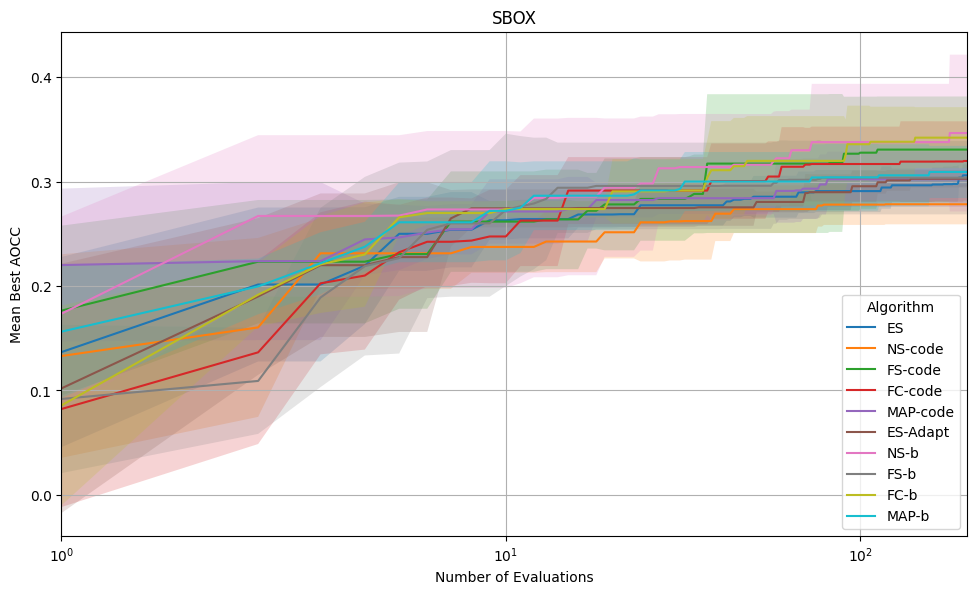

In [3]:
fig = plot_convergence(logger, metric="AOCC", save=False, return_fig=True, budget=200)
ax = fig.axes[0]   # or however you're getting your axis
ax.set_xscale('symlog')
#ax.set_yscale('symlog')
plt.show()

/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/numpy/_co

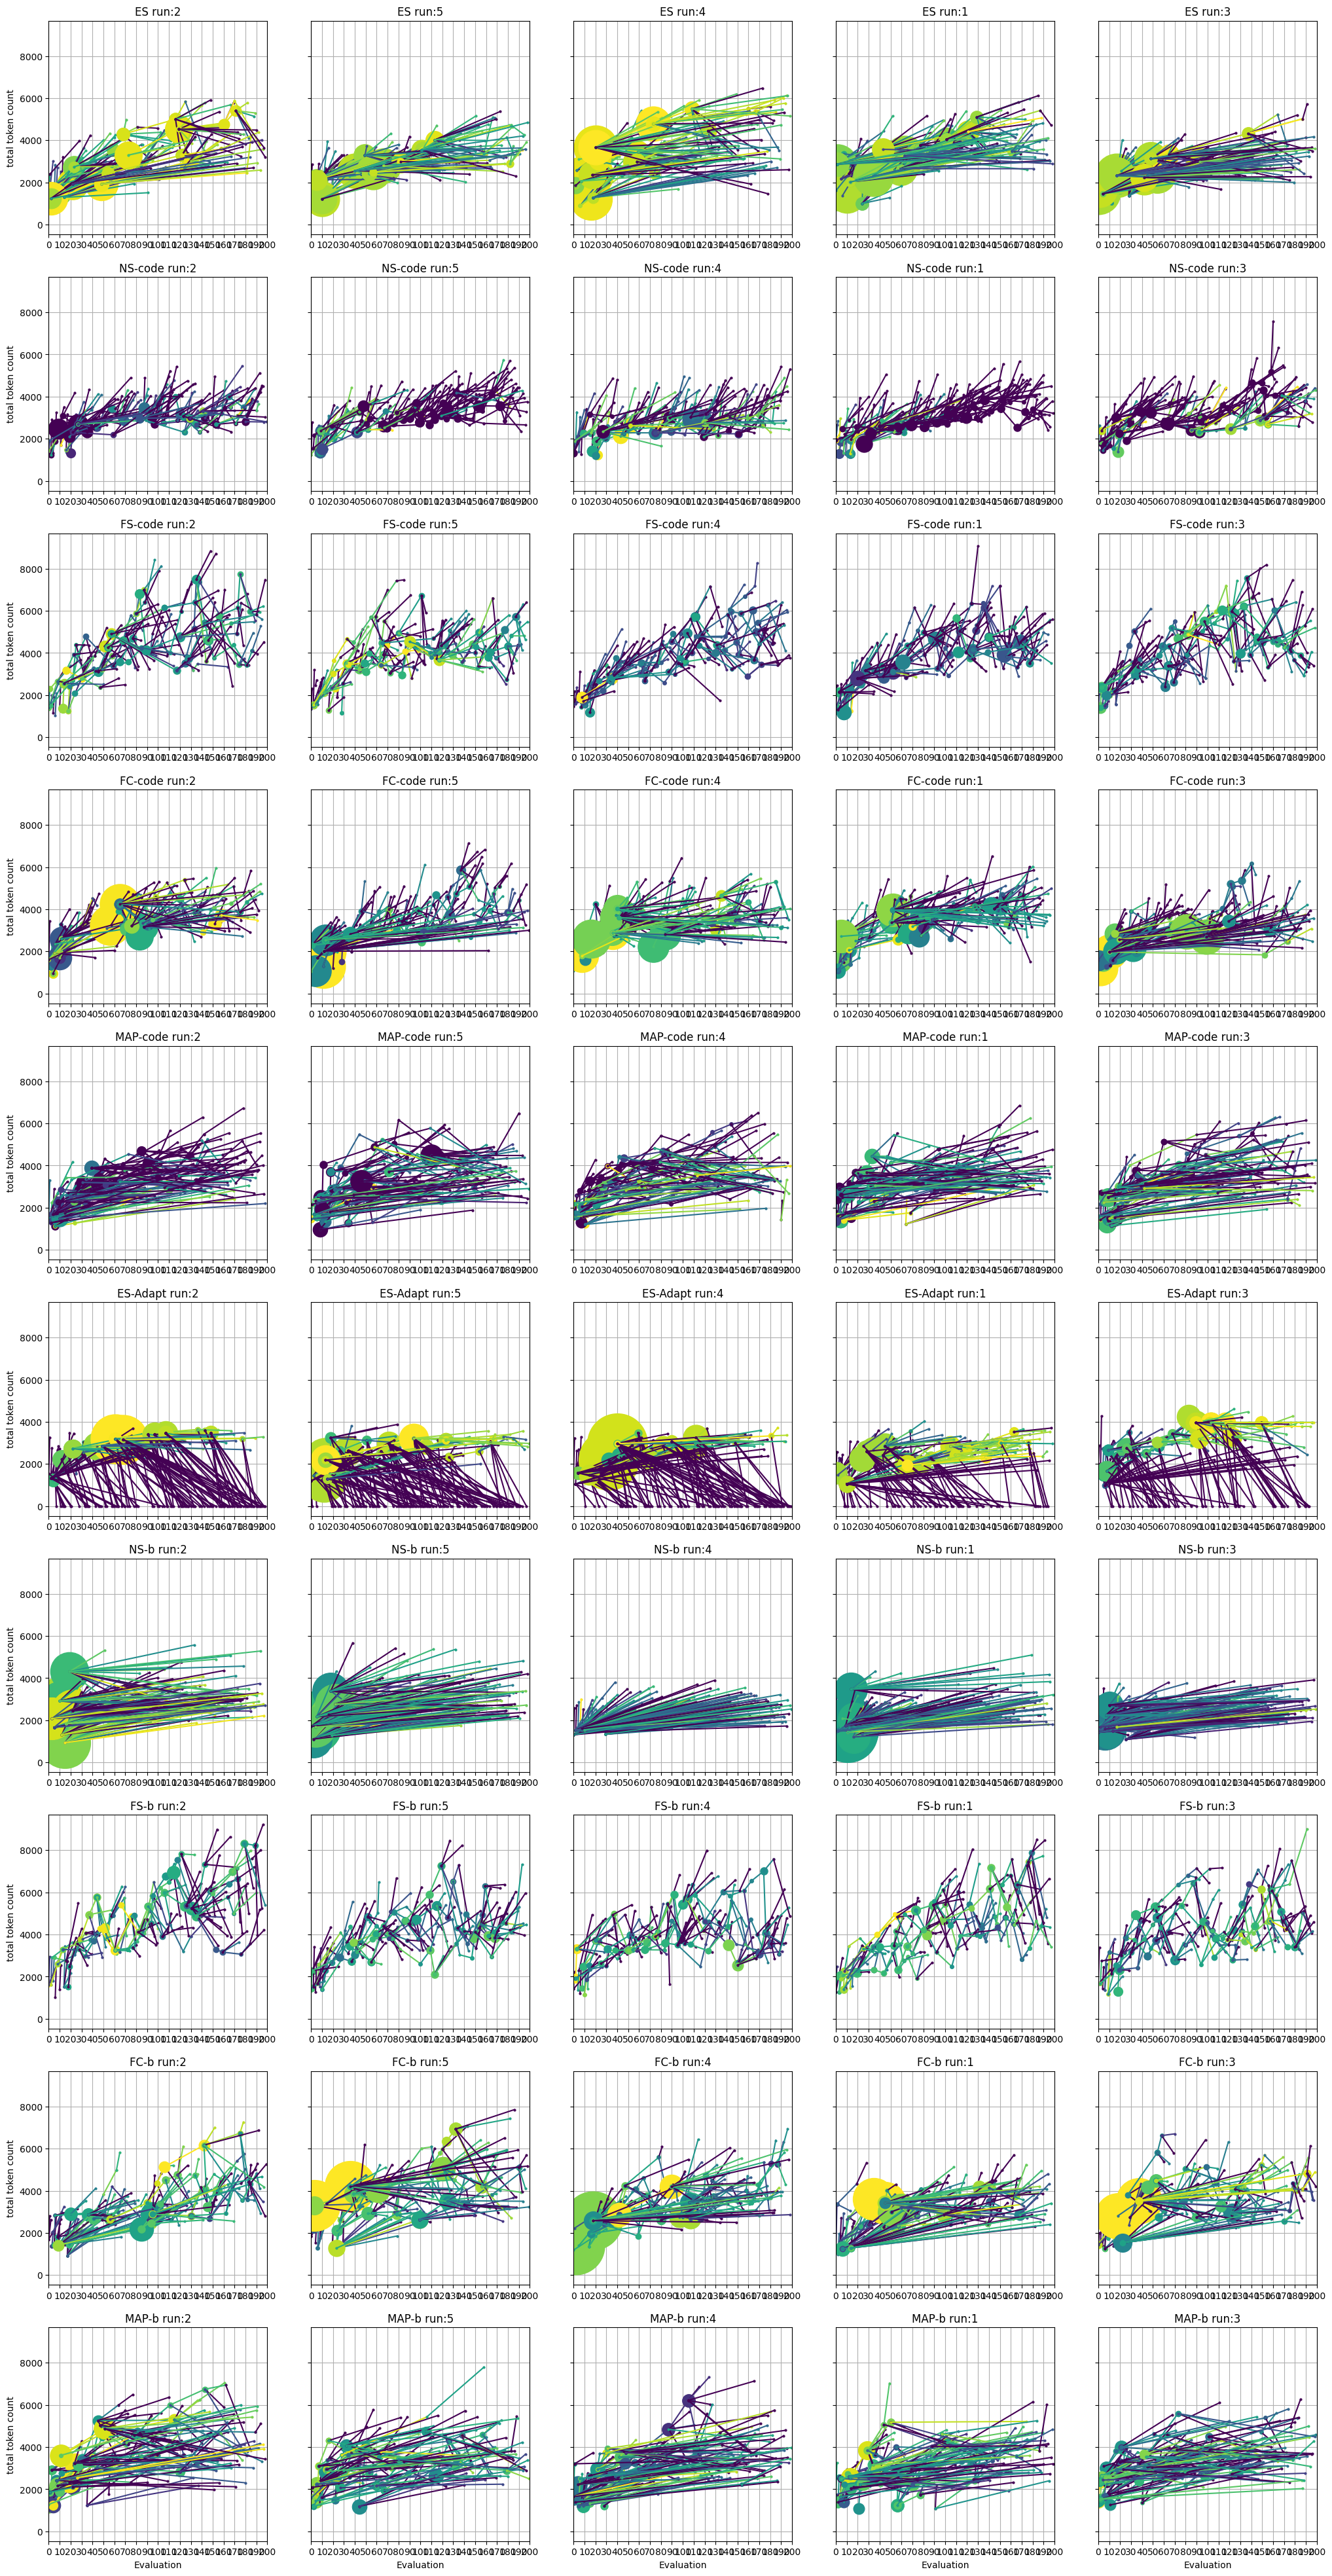

In [4]:
plot_experiment_CEG(logger, save=False, budget=200, max_seeds=5)

In [7]:
from scipy.stats import ttest_ind
def create_latex_table(df, alpha=0.05, smaller_is_better=False, problems=None):
    """
    Creates a LaTeX table with rows = methods, columns = problems.
    Each cell shows mean ± std (p=...).
    Cells are bolded if that method is significantly better than all others (p < alpha)
    for the given problem.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Must contain at least:
          - 'problem_name'
          - 'method_name'
          - 'solution' (dict with key 'fitness')
    alpha : float
        Significance level for p-value cutoff.
    smaller_is_better : bool
        If True, we treat lower fitness as “better.” Otherwise, higher is “better.”
    """
    # Ensure there's a 'fitness' column
    if 'fitness' not in df.columns:
        df['fitness'] = df['solution'].apply(lambda sol: sol.get('fitness', float('nan')))

    # Group data by (problem_name, method_name)
    # We'll store the runs for each combination so we can compute stats and pairwise tests
    grouped = df.groupby(['problem_name', 'method_name'])['fitness']
    stats_dict = { (p, m): grouped.get_group((p, m)).values 
                   for p, m in grouped.groups }

    if problems is None:
        problems = sorted(df['problem_name'].unique())
    methods = sorted(df['method_name'].unique())

    # Prepare a 2D structure for the table: rows=methods, cols=problems
    table_values = []

    for method in methods:
        row_entries = []
        for problem in problems:
            # Retrieve all runs for (problem, method)
            arr = stats_dict.get((problem, method), np.array([]))
            if len(arr) == 0:
                row_entries.append("N/A")
                continue

            mean_val = np.mean(arr)
            std_val = np.std(arr)
            
            # Compare this method’s distribution to each other method
            # We'll do a t-test and check p-value
            # For "significantly better than all others" we need:
            # 1) The comparison with each other method's distribution has p < alpha
            # 2) The mean is "better" (depending on smaller_is_better).
            all_better = True
            pvals = []
            for other_method in methods:
                if other_method == method:
                    continue
                other_arr = stats_dict.get((problem, other_method), np.array([]))
                if len(other_arr) == 0:
                    # If there’s no data for the other method, skip
                    continue

                # Mean comparison
                other_mean = np.mean(other_arr)
                is_better = (mean_val < other_mean) if smaller_is_better else (mean_val > other_mean)
                if not is_better:
                    all_better = False

                # Significance test
                # (We could use ttest_ind, Mann-Whitney U, etc. Here we do ttest_ind.)
                _, pval = ttest_ind(arr, other_arr, equal_var=False)
                pvals.append(pval)

            # We'll store the *maximum* p-value among all pairwise comparisons, 
            # because for the method to be "significantly better than all others",
            # *every* p-value must be below alpha.
            max_p = max(pvals) if pvals else 1.0

            cell_str = f"{mean_val:.2f} ± {std_val:.2f}"
            if all_better and (max_p < alpha):
                cell_str = "\\textbf{" + cell_str + "} "+f"(p={max_p:.3f})"
            row_entries.append(cell_str)
        table_values.append(row_entries)

    # Create a DataFrame of the final strings so we can export to LaTeX nicely
    table_df = pd.DataFrame(table_values, index=methods, columns=problems)

    return table_df